## Section 0 - Imports

In [1]:
# %matplotlib qt
import numpy as np
import matplotlib.pyplot as plt
import cv2
import h5py
from scipy import ndimage
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.manifold import TSNE
from skimage.color import lab2rgb , rgb2lab
from skimage import feature
from skimage import filters

import scipy.fftpack
import scipy.signal as signal

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.cluster import KMeans

import copy
import time

from openTSNE import TSNE as opTSNE

from sklearn.mixture import GaussianMixture 
from scipy.stats import multivariate_normal
import imageio
from functools import reduce

'''
import matplotlib
import scipy
import sklearn
import skimage
import mpl_toolkits
import openTSNE
'''

'\nimport matplotlib\nimport scipy\nimport sklearn\nimport skimage\nimport mpl_toolkits\nimport openTSNE\n'

In [2]:
'''


print("numpy = " + np.__version__)
print("matplotlib = " + matplotlib.__version__)
print("h5py = " + h5py.__version__)
print("scipy = " + scipy.__version__)
print("pandas = " + pd.__version__)
print("sklearn = " + sklearn.__version__)
print("skimage = " + skimage.__version__)
print("seaborn = " + sns.__version__)
print("openTSNE = " + openTSNE.__version__)

'''

'\n\n\nprint("numpy = " + np.__version__)\nprint("matplotlib = " + matplotlib.__version__)\nprint("h5py = " + h5py.__version__)\nprint("scipy = " + scipy.__version__)\nprint("pandas = " + pd.__version__)\nprint("sklearn = " + sklearn.__version__)\nprint("skimage = " + skimage.__version__)\nprint("seaborn = " + sns.__version__)\nprint("openTSNE = " + openTSNE.__version__)\n\n'

## Section 1 - Data Preparation

In [3]:
h5 = h5py.File('GastricData.mat', 'r')

#print(list(h5.keys()))

# Get all data variables and store them

# Clinical_data not read correctly, read by CSV
#Clinical_data= h5.get('Clinical_data')[:]

HE_image= h5.get('HE_image')[:]
HE_image = HE_image.swapaxes(0,2)


MSI_data_cube= h5.get('MSI_data_cube')[:]
MSI_data_cube = MSI_data_cube.swapaxes(0,2)

goodlist= h5.get('goodlist')[:]
goodlist = goodlist.swapaxes(0,1)

peak_list= h5.get('peak_list')[:]
peak_list = peak_list.swapaxes(0,1)

pixel_to_sample_ID= h5.get('pixel_to_sample_ID')[:]
pixel_to_sample_ID = pixel_to_sample_ID.swapaxes(0,1)  

h5.close()

# Clinical_data = pd.read_excel('ClinicalData.xlsx')

height , width = (pixel_to_sample_ID.shape) # ( 443 , 1653 )

flattened_MSI_data_cube = MSI_data_cube.flatten().reshape(MSI_data_cube.shape[0] * MSI_data_cube.shape[1] , MSI_data_cube.shape[2])

# The scaler object (model)
scaler = StandardScaler()
# fit and transform the data
scaled_data = scaler.fit_transform(flattened_MSI_data_cube) 

flattened_pixel_to_sample_ID = pixel_to_sample_ID.flatten() 

indices = np.where(flattened_pixel_to_sample_ID == -1)
indices_sampleID = np.where(flattened_pixel_to_sample_ID == -1 )

In [4]:
scaled_data.shape


(732279, 82)

In [5]:
Sample_1 = 1
Sample_2 = 18
Sample_3 = 59

In [6]:
sample_only_scaled_data = np.delete(scaled_data, indices[0] , axis=0)
sample_ID_pixels = np.delete(flattened_pixel_to_sample_ID , indices_sampleID[0] , axis=0)
original_sample_ID_pixels = copy.deepcopy(sample_ID_pixels)

# Pick 3 samples
mask = (sample_ID_pixels == Sample_1 ) 
samples_selected = sample_ID_pixels
samples_selected[mask] = 100

mask = (sample_ID_pixels == Sample_2 ) 
samples_selected[mask] = 200

mask = (sample_ID_pixels == Sample_3 ) 
samples_selected[mask] = 300

# Make other samples the same low intensity color
mask = (sample_ID_pixels <= 63) 
samples_selected[mask] = 1

## Section 2 - PCA

In [7]:
pca = PCA(n_components=5)
pca_result = pca.fit_transform(sample_only_scaled_data)

pca_df = pd.DataFrame(data=pca_result[:],columns=["PC1","PC2","PC3","PC4","PC5"])
print('Explained variation per PC: {}'.format(pca.explained_variance_ratio_))
variance = pca.explained_variance_ratio_

Explained variation per PC: [0.17506106 0.09651383 0.06742341 0.0467137  0.04414016]


Text(0, 0.5, 'Variance Percentage')

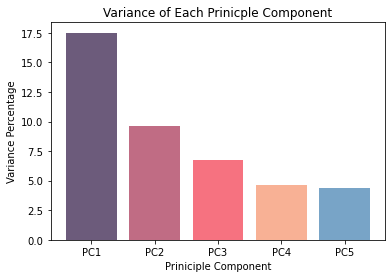

In [8]:
PCA=["PC1","PC2","PC3","PC4","PC5"]

COLORS = ["#6C5B7B","#C06C84","#F67280","#F8B195", "#78a4c7"]

plt.bar(PCA, variance*100, color=COLORS)

plt.title('Variance of Each Prinicple Component')
plt.xlabel('Priniciple Component')
plt.ylabel('Variance Percentage')

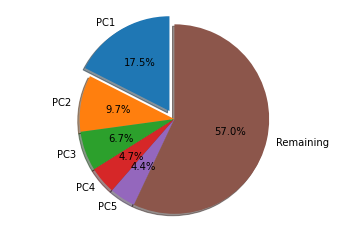

Variance Represented by PCA = 42.99 %


In [9]:
# Pie chart
labels = 'PC1', 'PC2', 'PC3', 'PC4' , 'PC5' , 'Remaining'
sizes = [ variance[0], variance[1], variance[2], variance[3] , variance[4] , 1 - ( variance[0] + variance[1] + variance[2] + variance[3] + variance[4] )  ]
explode = (0.1, 0, 0, 0, 0, 0) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, normalize=False)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()
print('Variance Represented by PCA = ' + str(round((variance[0] + variance[1] + variance[2] + variance[3] + variance[4])*100 , 2) ) +' %')

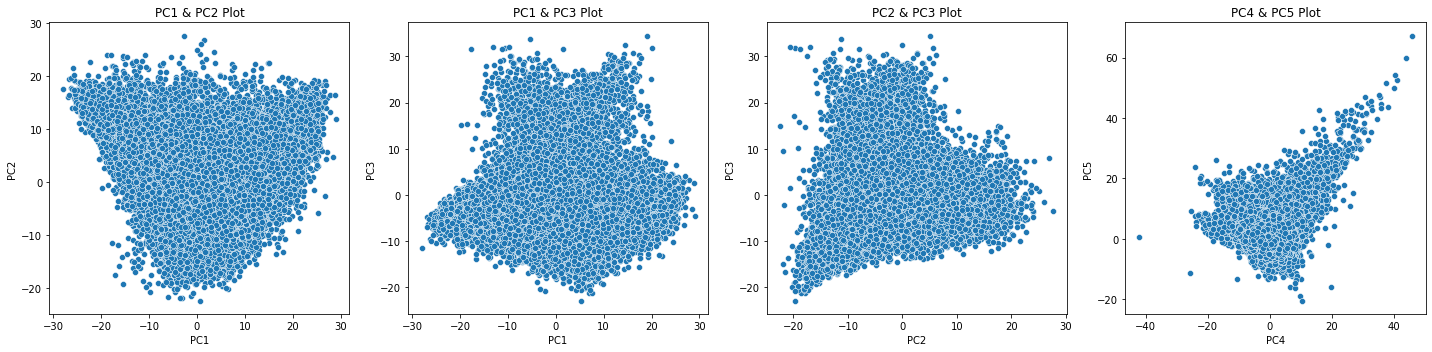

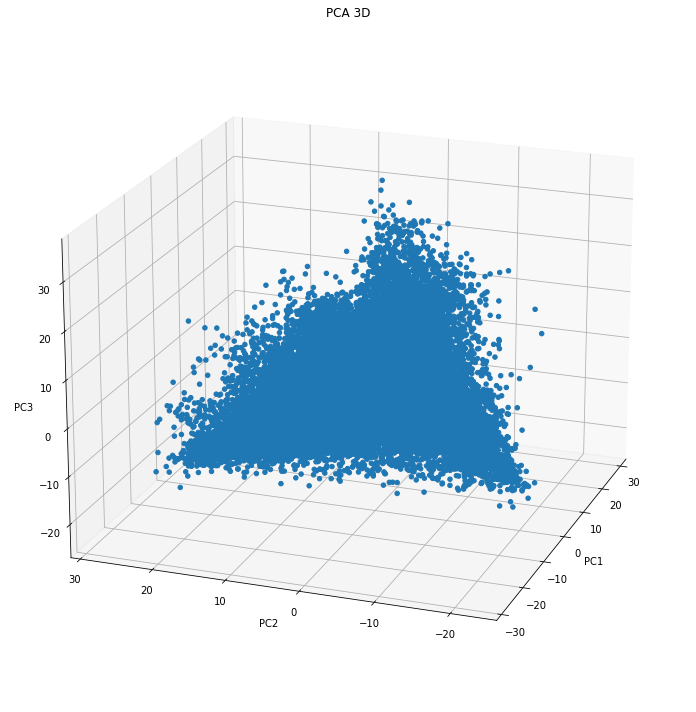

In [10]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
# sns.set(rc = {'figure.figsize':(15,8)})

sns.scatterplot(
    ax=axes[0],
    x="PC1", y="PC2",
    palette=sns.color_palette("icefire"),
    data=pca_df
)
axes[0].set_title("PC1 & PC2 Plot")
sns.scatterplot(
    ax=axes[1],
    x="PC1", y="PC3",
    palette=sns.color_palette("icefire"),
    data=pca_df
)
axes[1].set_title("PC1 & PC3 Plot")
sns.scatterplot(
    ax=axes[2],
    x="PC2", y="PC3",
    palette=sns.color_palette("icefire"),
    data=pca_df
)
axes[2].set_title("PC2 & PC3 Plot")

sns.scatterplot(
    ax=axes[3],
    x="PC4", y="PC5",
    palette=sns.color_palette("icefire"),
    data=pca_df
)
axes[3].set_title("PC4 & PC5 Plot")

plt.tight_layout()
plt.show()

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
scatter_3d = ax.scatter(
    xs=pca_df['PC1'], 
    ys=pca_df['PC2'], 
    zs=pca_df['PC3'], 
    alpha = 1
)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title("PCA 3D")

fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# elev is z-axis, +ve moves up, -ve moves down
# azim is x axis, +ve moves right, -ve moves left
ax.view_init(elev = 20 , azim = -160) 
plt.tight_layout()


## Section 3 - tSNE

In [11]:
'''
time_start = time.time()
tsne = opTSNE(
    n_components = 3,
    perplexity = 40,
    learning_rate = 'auto',
    early_exaggeration_iter = 50,
    early_exaggeration = 4,
    n_iter = 1000,
    initialization = 'random',
    initial_momentum = 0.5,
    final_momentum = 0.8,
    metric="euclidean",
    n_jobs=8,
    random_state=0,
    negative_gradient_method = 'barnes-hut',
    verbose=True,
)

%time tsne_results_op = tsne.fit(sample_only_scaled_data)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

np.save('op_tSNE_Results_' + 'Time_{}_seconds'.format(time.time()-time_start) , tsne_results)
'''

'\ntime_start = time.time()\ntsne = opTSNE(\n    n_components = 3,\n    perplexity = 40,\n    learning_rate = \'auto\',\n    early_exaggeration_iter = 50,\n    early_exaggeration = 4,\n    n_iter = 1000,\n    initialization = \'random\',\n    initial_momentum = 0.5,\n    final_momentum = 0.8,\n    metric="euclidean",\n    n_jobs=8,\n    random_state=0,\n    negative_gradient_method = \'barnes-hut\',\n    verbose=True,\n)\n\n%time tsne_results_op = tsne.fit(sample_only_scaled_data)\n\nprint(\'t-SNE done! Time elapsed: {} seconds\'.format(time.time()-time_start))\n\nnp.save(\'op_tSNE_Results_\' + \'Time_{}_seconds\'.format(time.time()-time_start) , tsne_results)\n'

In [12]:
# Util function for convert-to (0 - 1) range
def rescale(arr):
    arr_min = arr.min()
    arr_max = arr.max()
    return (arr - arr_min) / (arr_max - arr_min)
def rescale_AB(arr):
    arr_min = arr.min()
    arr_max = arr.max()
    return ( (arr - arr_min) / (arr_max - arr_min)  ) * 255 - 128

In [13]:
# Load the t-SNE results
op_tsne_results = np.load('op_tSNE_Results_Time_456.8306334018707_seconds.npy')

In [14]:
tsne_df = pd.DataFrame(data=op_tsne_results[:],columns=["tSNE_dim1","tSNE_dim2","tSNE_dim3"])
tsne_df['pixel_ID'] = samples_selected
tsne_df['L_Component'] = op_tsne_results[:,0]
tsne_df['A_Component'] = op_tsne_results[:,1]
tsne_df['B_Component'] = op_tsne_results[:,2]

In [15]:
# Converting tSNE dimensions to be represented 

LAB_mapping = [ tsne_df['L_Component'] , tsne_df['A_Component'] , tsne_df['B_Component'] ]
LAB_colors = np.asarray(LAB_mapping)
LAB_colors = LAB_colors.swapaxes(0,1)

L = rescale(LAB_colors[:,0]) * 100
A = rescale_AB(LAB_colors[:,1])
B = rescale_AB(LAB_colors[:,2])
LAB_colors = np.asarray( [ L , A , B ] )
LAB_colors = LAB_colors.swapaxes(0,1)
RGB_colors = lab2rgb(LAB_colors)


C:\Users\omars\anaconda3\lib\site-packages\skimage\color\colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1504 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


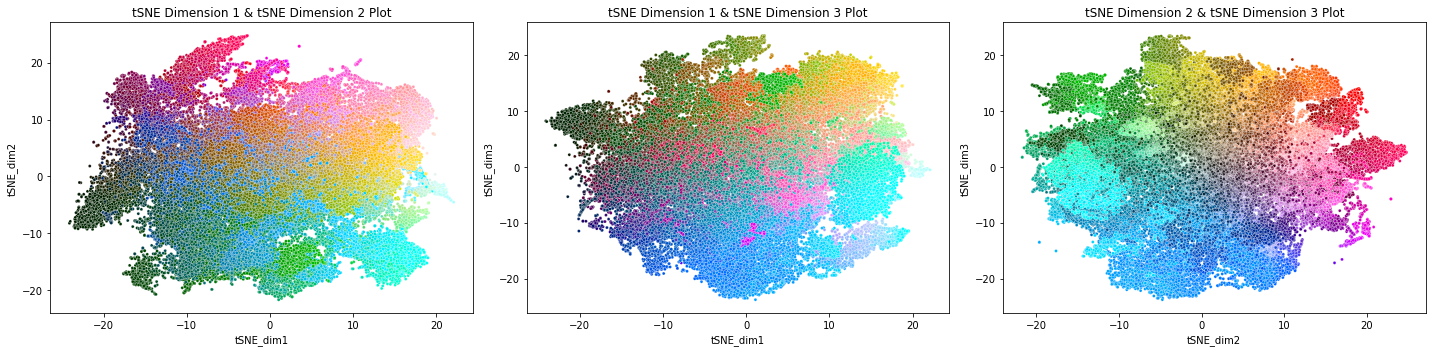

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
# sns.set(rc = {'figure.figsize':(15,8)})
marker_size = 9

sns.scatterplot(
    ax = axes[0],
    x = "tSNE_dim1", y="tSNE_dim2",
    c = RGB_colors,
    s = marker_size,
    data = tsne_df
)
axes[0].set_title("tSNE Dimension 1 & tSNE Dimension 2 Plot")

sns.scatterplot(
    ax = axes[1],
    x = "tSNE_dim1", y="tSNE_dim3",
    c = RGB_colors,
    s = marker_size,
    data = tsne_df
)
axes[1].set_title("tSNE Dimension 1 & tSNE Dimension 3 Plot")

sns.scatterplot(
    ax = axes[2],
    x = "tSNE_dim2", y="tSNE_dim3",
    c = RGB_colors,
    s = marker_size,
    data = tsne_df
)
axes[2].set_title("tSNE Dimension 2 & tSNE Dimension 3 Plot")



plt.tight_layout()
plt.show()



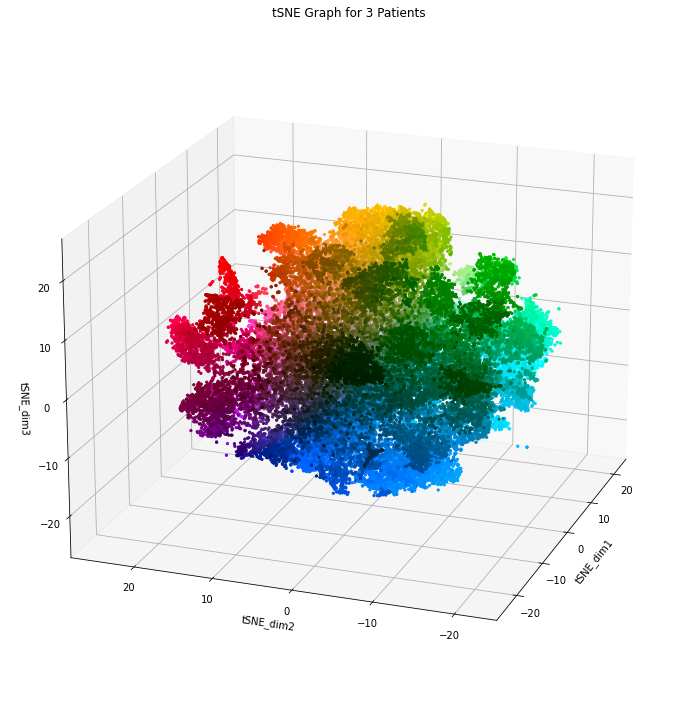

In [17]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
scatter_3d = ax.scatter(
    xs=tsne_df['tSNE_dim1'], 
    ys=tsne_df['tSNE_dim2'], 
    zs=tsne_df['tSNE_dim3'], 
    c = RGB_colors,
    s = 5,
    alpha = 1,
)

ax.set_xlabel('tSNE_dim1')
ax.set_ylabel('tSNE_dim2')
ax.set_zlabel('tSNE_dim3')
ax.set_title("tSNE Graph for 3 Patients")

# fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# elev is z-axis, +ve moves up, -ve moves down
# azim is x axis, +ve moves right, -ve moves left
ax.view_init(elev = 20 , azim = -160) 
plt.tight_layout()


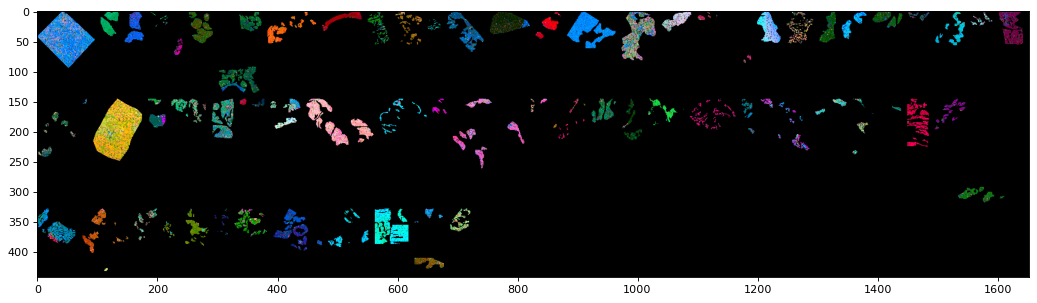

In [18]:
indices_edit = np.where(pixel_to_sample_ID != -1)
tsne_image = np.zeros( (height,width,3) )
increment = 0

for i,j in zip(indices_edit[0],indices_edit[1]):
    tsne_image[i][j][0] = RGB_colors[increment][0]
    tsne_image[i][j][1] = RGB_colors[increment][1]
    tsne_image[i][j][2] = RGB_colors[increment][2]
    increment += 1

plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(tsne_image)


## Section 4 - Kmeans

In [50]:
############# Sklearn K-mean #################
kmeans_3 = KMeans(n_clusters=3, n_init=10, max_iter=2000, random_state=42, verbose=0 ).fit(op_tsne_results)
kmeans_4 = KMeans(n_clusters=4, n_init=100, max_iter=2000, random_state=42, verbose=0 ).fit(op_tsne_results)
kmeans_5 = KMeans(n_clusters=5, n_init=100, max_iter=2000, random_state=42, verbose=0 ).fit(op_tsne_results)


In [51]:
indices_edit = np.where(pixel_to_sample_ID != -1)
KMeans_image_3 = np.full( (height,width),-1 )
KMeans_image_4 = np.full( (height,width),-1 )
KMeans_image_5 = np.full( (height,width),-1 )
increment = 0
for i,j in zip(indices_edit[0],indices_edit[1]):
    KMeans_image_3[i][j] = kmeans_3.labels_[increment]
    KMeans_image_4[i][j] = kmeans_4.labels_[increment]
    KMeans_image_5[i][j] = kmeans_5.labels_[increment]

    increment += 1

In [52]:
cvals = [0, 1, 2,3,4,5]
colors = ["black","#16235A","#F28A30","#888C46", "#EBF2EA","#0ABDA0"] #PURPLE, #DARK BLUE, #

norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = LinearSegmentedColormap.from_list("", tuples)


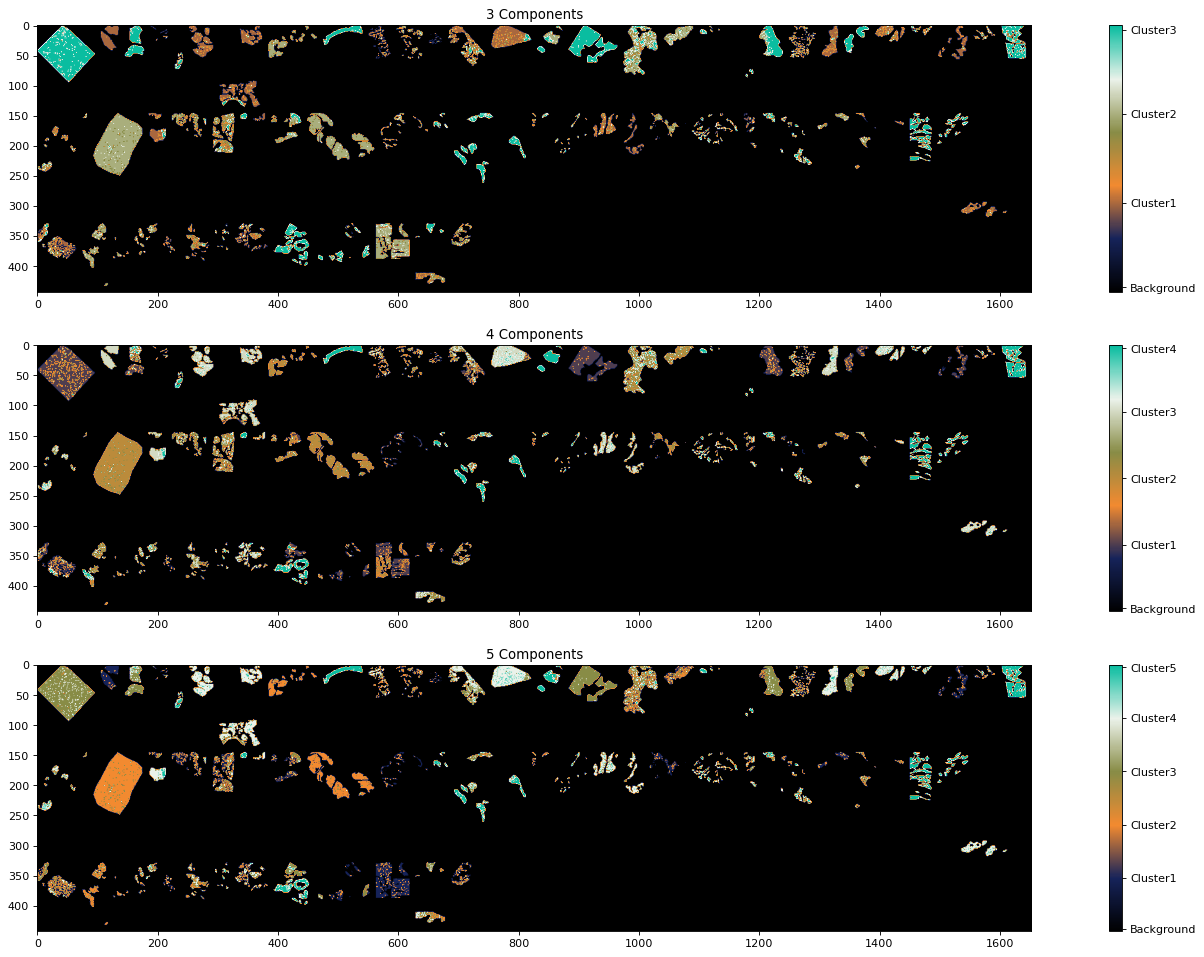

In [53]:
plt.figure(figsize=(25, 15), dpi=80)
plt.figure(1)
plt.subplot(311)
plt.title("3 Components")
plt.imshow(KMeans_image_3, cmap=cmap)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 1.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3"])

plt.subplot(312)
plt.title("4 Components")
plt.imshow(KMeans_image_4, cmap=cmap)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 2,2.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3" , "Cluster4"])


plt.subplot(313)
plt.title("5 Components")
plt.imshow(KMeans_image_5, cmap=cmap)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 2 , 3 , 3.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3","Cluster4","Cluster5"])

plt.show()


In [55]:
specific_index = 13
mask = (pixel_to_sample_ID == specific_index) 
labels_indicies = np.where(mask == True)

padding_factor = 0

zoomed_height_max = max(labels_indicies[0]) + padding_factor
zoomed_height_min = min(labels_indicies[0]) - padding_factor
zoomed_width_max = max(labels_indicies[1]) + padding_factor
zoomed_width_min = min(labels_indicies[1]) - padding_factor


zoomedIn_image_3 = KMeans_image_3[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]
zoomedIn_image_4 = KMeans_image_4[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]
zoomedIn_image_5 = KMeans_image_5[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]


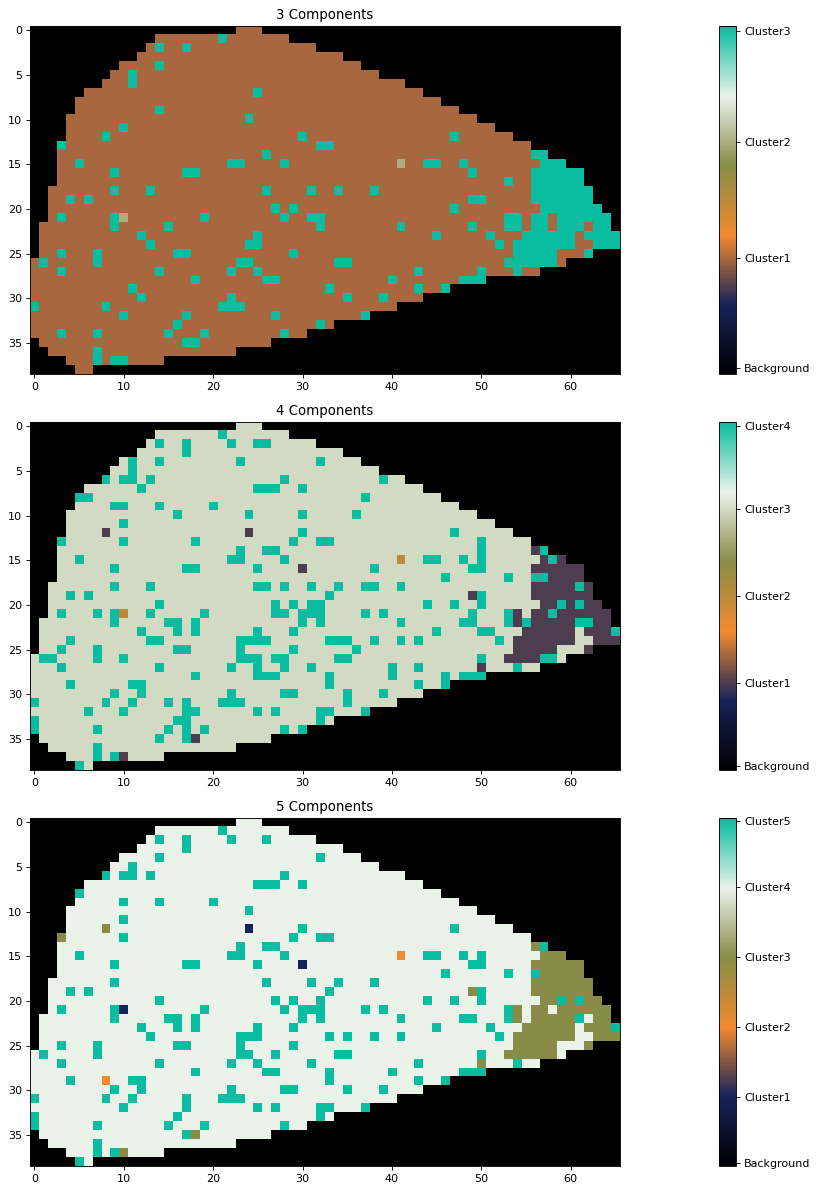

In [57]:
plt.figure(figsize=(25, 15), dpi=80)
plt.figure(1)
plt.subplot(311)
plt.title("3 Components")
plt.imshow(zoomedIn_image_3, cmap=cmap)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 1.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3"])

plt.subplot(312)
plt.title("4 Components")
plt.imshow(zoomedIn_image_4, cmap=cmap)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 2,2.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3" , "Cluster4"])

plt.subplot(313)
plt.title("5 Components")
plt.imshow(zoomedIn_image_5, cmap=cmap)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 2 , 3 , 3.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3","Cluster4","Cluster5"])
plt.tight_layout()
plt.show()

## Section 5 - Bisecting Kmeans


In [26]:
from sklearn.utils import shuffle

def initialCentroids(matrix):
    matrixShuffled = shuffle(matrix, random_state=0)
    return matrixShuffled[:2,:]

def similarity(matrix, centroids):
    similarities = matrix.dot(centroids.T)
    return similarities
def findClusters(matrix, centroids):
    
    clusterA = list()
    clusterB = list()
    
    similarityMatrix = similarity(matrix, centroids)
    
    for index in range(similarityMatrix.shape[0]):
        similarityRow = similarityMatrix[index]
        
        #Sort the index of the matrix in ascending order of value and get the index of the last element
        #This index will be the cluster that the row in input matrix will belong to
        similaritySorted = np.argsort(similarityRow)[-1]
        
        if similaritySorted == 0:
            clusterA.append(index)
        else:
            clusterB.append(index)
        
    return clusterA, clusterB

def recalculateCentroid(matrix, clusters):
    centroids = list()
    
    for i in range(0,2):
        cluster = matrix[clusters[i],:]
        clusterMean = cluster.mean(0)
        centroids.append(clusterMean)
        
    centroids_array = np.asarray(centroids)
    
    return centroids_array

def calculateSSE(matrix, clusters):
    
    SSE_list = list()
    SSE_array = []
    
    for cluster in clusters:
        members = matrix[cluster,:]
        SSE = np.sum(np.square(members - np.mean(members)))
        SSE_list.append(SSE)
        
    SSE_array = np.asarray(SSE_list)
    dropClusterIndex = np.argsort(SSE_array)[-1]
            
    return dropClusterIndex

def kmeans(matrix, numberOfIterations):
    
    centroids = initialCentroids(matrix)
    
    for _ in range(numberOfIterations):
        
        clusters = list()
        
        clusterA, clusterB = findClusters(matrix, centroids)
        
        if len(clusterA) > 1:
            clusters.append(clusterA)
        if len(clusterB) > 1:
            clusters.append(clusterB)
            
        centroids = recalculateCentroid(matrix, clusters)
        
    return clusterA, clusterB



def bisecting_kmeans(matrix, k, numberOfIterations):
    
    clusters = list()
    
    initialcluster = list()
    for i in range(matrix.shape[0]):
        initialcluster.append(i)
    
    clusters.append(initialcluster)
    
    while len(clusters) < k:

        dropClusterIndex = calculateSSE(matrix, clusters)
        droppedCluster = clusters[dropClusterIndex]
        
        clusterA, clusterB = kmeans(matrix[droppedCluster,:], numberOfIterations)
        del clusters[dropClusterIndex]
        
        actualClusterA = list()
        actualClusterB = list()
        for index in clusterA:
            actualClusterA.append(droppedCluster[index])
            
        for index in clusterB:
            actualClusterB.append(droppedCluster[index])
        
        clusters.append(actualClusterA)
        clusters.append(actualClusterB)
    
    labels = [0] * matrix.shape[0]

    for index, cluster in enumerate(clusters):
        for idx in cluster:
            labels[idx] = index + 1
    return labels

In [27]:
labels_3 = np.array(bisecting_kmeans(op_tsne_results , 3, 10) ) - 1
labels_4 = np.array(bisecting_kmeans(op_tsne_results , 4, 10) ) - 1
labels_5 = np.array(bisecting_kmeans(op_tsne_results , 5, 10) ) - 1

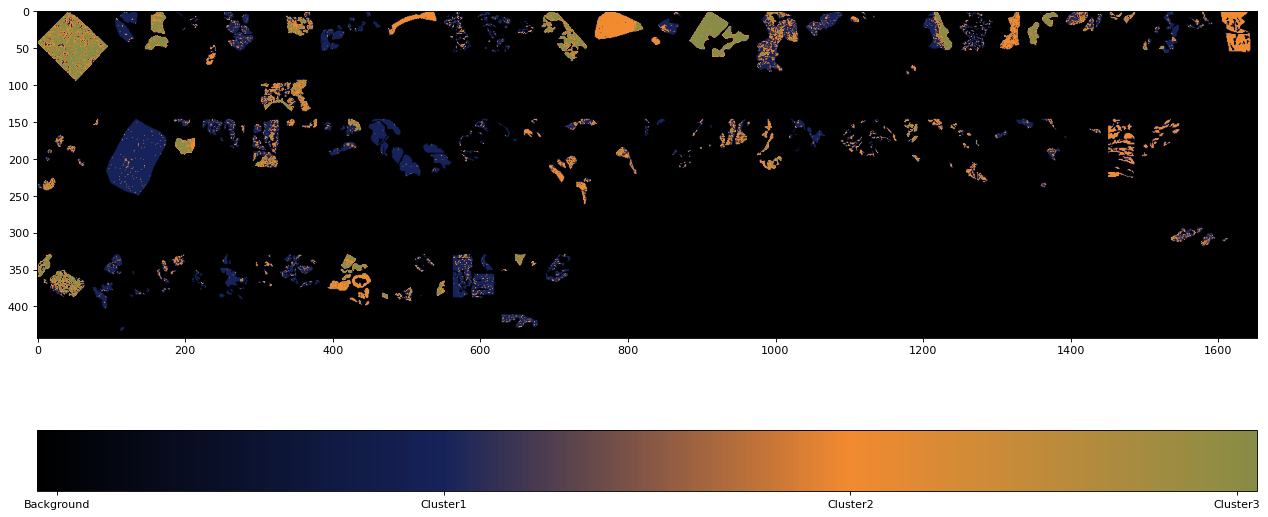

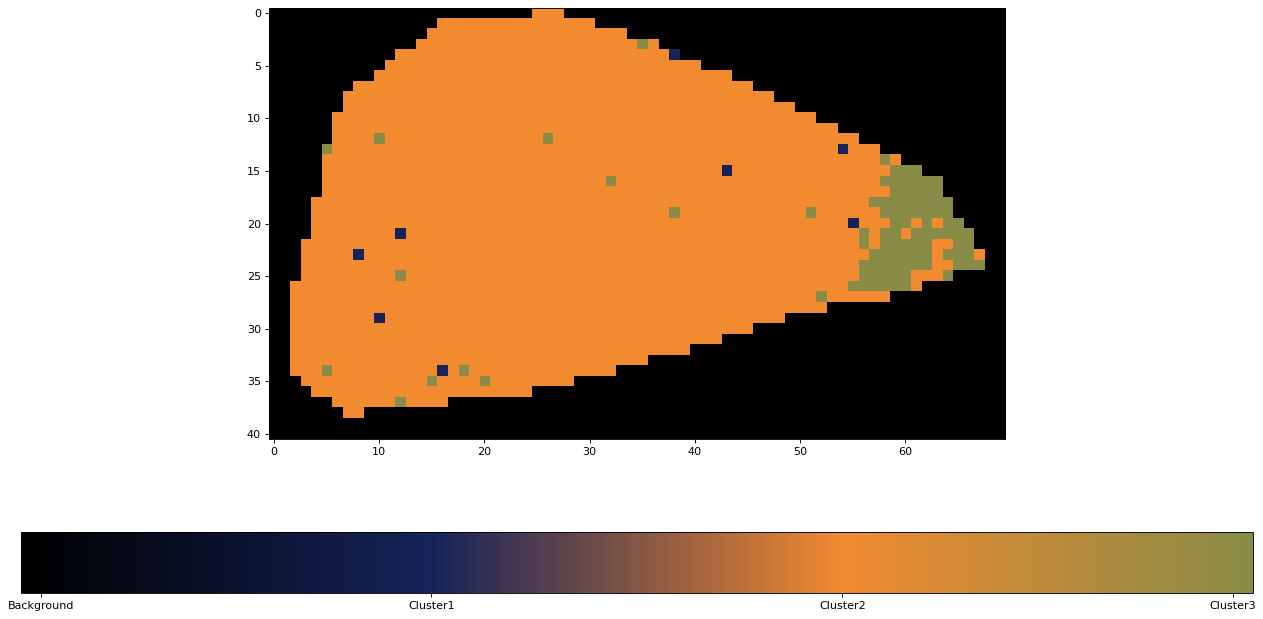

In [28]:
# 3 Components Bisecting Kmeans

indices_edit = np.where(pixel_to_sample_ID != -1)
bisecting_kmeans_image = np.full( (height,width),-1 )
increment = 0
for i,j in zip(indices_edit[0],indices_edit[1]):
    bisecting_kmeans_image[i][j] = labels_3[increment]
    increment += 1

# Coloring the K-means image with specific chosen colors)

cvals = [0, 1, 2,3]
colors = ["black","#16235A","#F28A30","#888C46"]

norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = LinearSegmentedColormap.from_list("", tuples)

plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(bisecting_kmeans_image, cmap=cmap)

colorbar = plt.colorbar(orientation = "horizontal")
colorbar.set_ticks([-0.95 , 0 , 1, 1.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3"])

plt.tight_layout()
# Zooming on sample id 13

specific_index = 13
mask = (pixel_to_sample_ID == specific_index) 
kmeans_labels_indicies = np.where(mask == True)

padding_factor = 2

zoomed_height_max = max(kmeans_labels_indicies[0]) + padding_factor
zoomed_height_min = min(kmeans_labels_indicies[0]) - padding_factor
zoomed_width_max = max(kmeans_labels_indicies[1]) + padding_factor
zoomed_width_min = min(kmeans_labels_indicies[1]) - padding_factor

if zoomed_height_max > height:
    zoomed_height_max= height

if zoomed_height_min < 0:
    zoomed_height_min= 0

if zoomed_width_max > width:
    zoomed_width_max= width

if zoomed_width_min < 0:
    zoomed_width_min= 0

bisectingkmeans_zoomedIn_image = bisecting_kmeans_image[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]
plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(bisectingkmeans_zoomedIn_image,cmap=cmap)
colorbar = plt.colorbar(orientation = "horizontal")
colorbar.set_ticks([-0.95 , 0 , 1, 1.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3"])

plt.tight_layout()


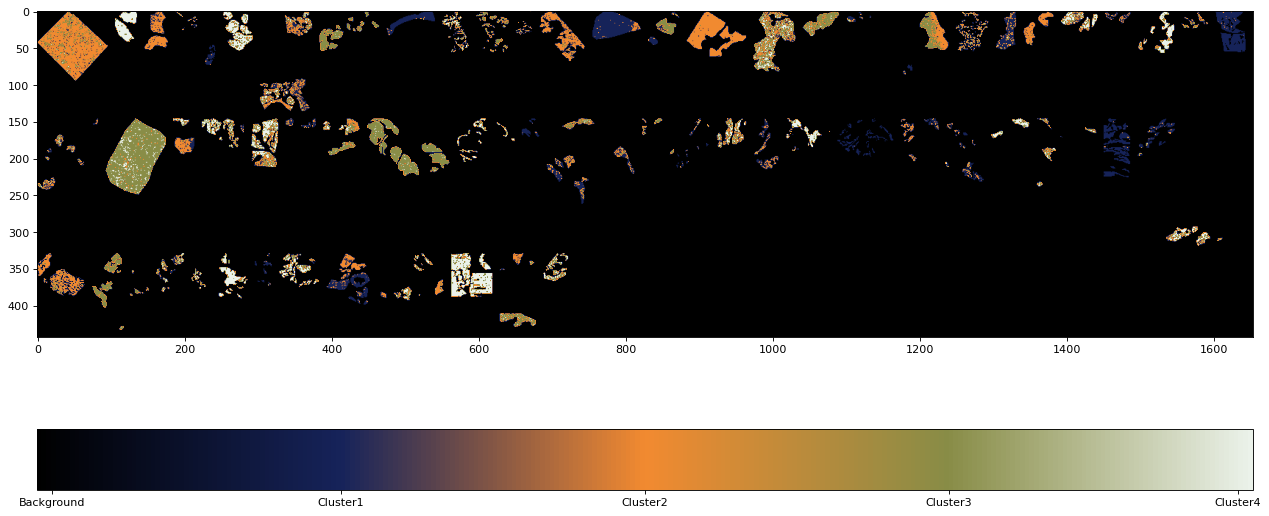

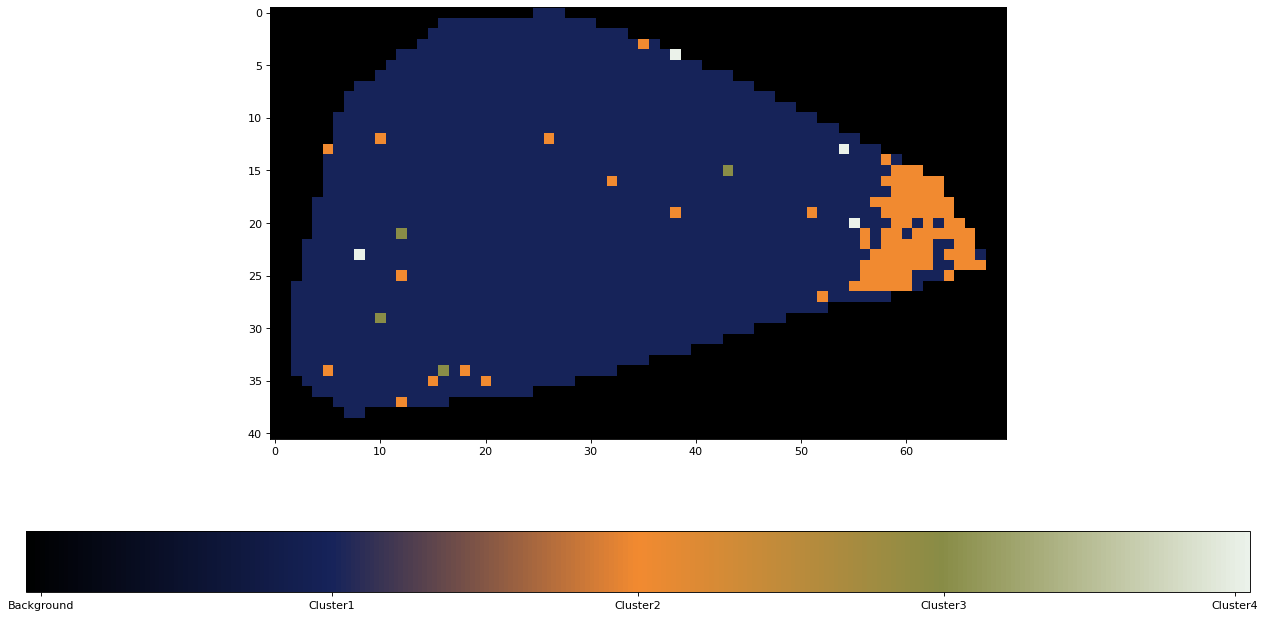

In [29]:
# 4 Components Bisecting Kmeans

indices_edit = np.where(pixel_to_sample_ID != -1)
bisecting_kmeans_image = np.full( (height,width),-1 )
increment = 0
for i,j in zip(indices_edit[0],indices_edit[1]):
    bisecting_kmeans_image[i][j] = labels_4[increment]
    increment += 1

# Coloring the K-means image with specific chosen colors)

cvals = [0, 1, 2,3,4]
colors = ["black","#16235A","#F28A30","#888C46", "#EBF2EA"]

norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = LinearSegmentedColormap.from_list("", tuples)

plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(bisecting_kmeans_image, cmap=cmap)

colorbar = plt.colorbar(orientation = "horizontal")
colorbar.set_ticks([-0.95 , 0 , 1, 2,2.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3" , "Cluster4"])

plt.tight_layout()
# Zooming on sample id 13

specific_index = 13
mask = (pixel_to_sample_ID == specific_index) 
kmeans_labels_indicies = np.where(mask == True)

padding_factor = 2

zoomed_height_max = max(kmeans_labels_indicies[0]) + padding_factor
zoomed_height_min = min(kmeans_labels_indicies[0]) - padding_factor
zoomed_width_max = max(kmeans_labels_indicies[1]) + padding_factor
zoomed_width_min = min(kmeans_labels_indicies[1]) - padding_factor

if zoomed_height_max > height:
    zoomed_height_max= height

if zoomed_height_min < 0:
    zoomed_height_min= 0

if zoomed_width_max > width:
    zoomed_width_max= width

if zoomed_width_min < 0:
    zoomed_width_min= 0

bisectingkmeans_zoomedIn_image = bisecting_kmeans_image[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]
plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(bisectingkmeans_zoomedIn_image,cmap=cmap)
colorbar = plt.colorbar(orientation = "horizontal")
colorbar.set_ticks([-0.95 , 0 , 1, 2,2.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3" , "Cluster4"])

plt.tight_layout()


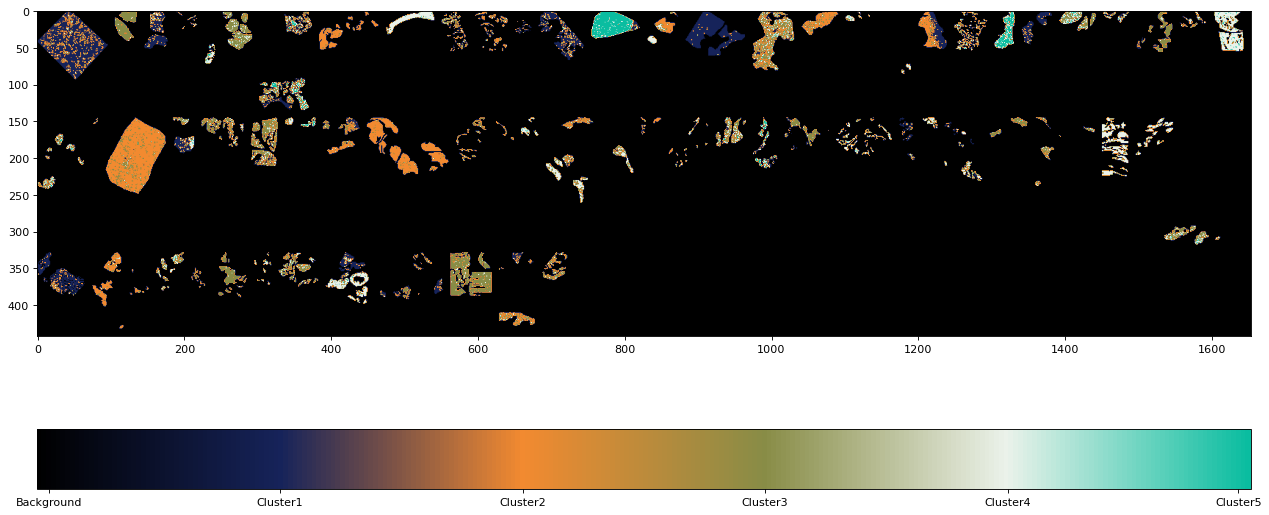

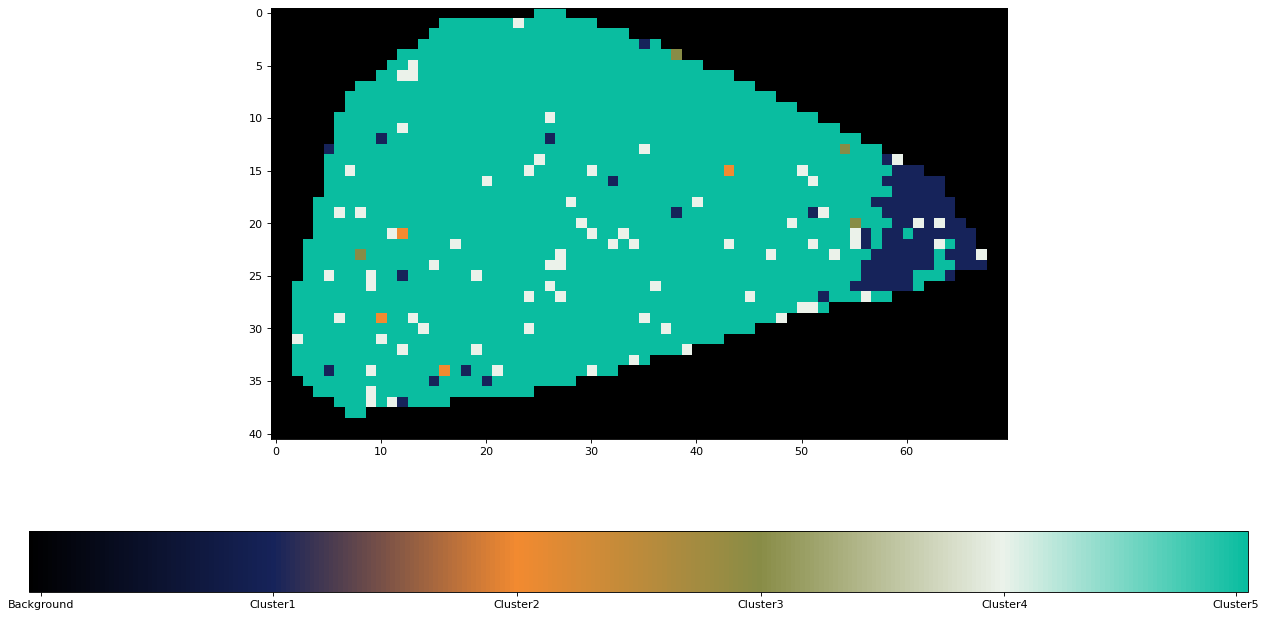

In [30]:
# 5 Components Bisecting Kmeans

indices_edit = np.where(pixel_to_sample_ID != -1)
bisecting_kmeans_image = np.full( (height,width),-1 )
increment = 0
for i,j in zip(indices_edit[0],indices_edit[1]):
    bisecting_kmeans_image[i][j] = labels_5[increment]
    increment += 1

# Coloring the K-means image with specific chosen colors)

cvals = [0, 1, 2,3,4,5]
colors = ["black","#16235A","#F28A30","#888C46", "#EBF2EA","#0ABDA0"] #PURPLE, #DARK BLUE, #

norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = LinearSegmentedColormap.from_list("", tuples)

plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(bisecting_kmeans_image, cmap=cmap)

colorbar = plt.colorbar(orientation = "horizontal")
colorbar.set_ticks([-0.95 , 0 , 1, 2 , 3 , 3.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3","Cluster4","Cluster5"])

plt.tight_layout()
# Zooming on sample id 13

specific_index = 13
mask = (pixel_to_sample_ID == specific_index) 
kmeans_labels_indicies = np.where(mask == True)

padding_factor = 2

zoomed_height_max = max(kmeans_labels_indicies[0]) + padding_factor
zoomed_height_min = min(kmeans_labels_indicies[0]) - padding_factor
zoomed_width_max = max(kmeans_labels_indicies[1]) + padding_factor
zoomed_width_min = min(kmeans_labels_indicies[1]) - padding_factor

if zoomed_height_max > height:
    zoomed_height_max= height

if zoomed_height_min < 0:
    zoomed_height_min= 0

if zoomed_width_max > width:
    zoomed_width_max= width

if zoomed_width_min < 0:
    zoomed_width_min= 0

bisectingkmeans_zoomedIn_image = bisecting_kmeans_image[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]
plt.figure(figsize=(16, 8), dpi=80)
plt.imshow(bisectingkmeans_zoomedIn_image,cmap=cmap)
colorbar = plt.colorbar(orientation = "horizontal")
colorbar.set_ticks([-0.95 , 0 , 1, 2 , 3 , 3.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3","Cluster4","Cluster5"])

plt.tight_layout()


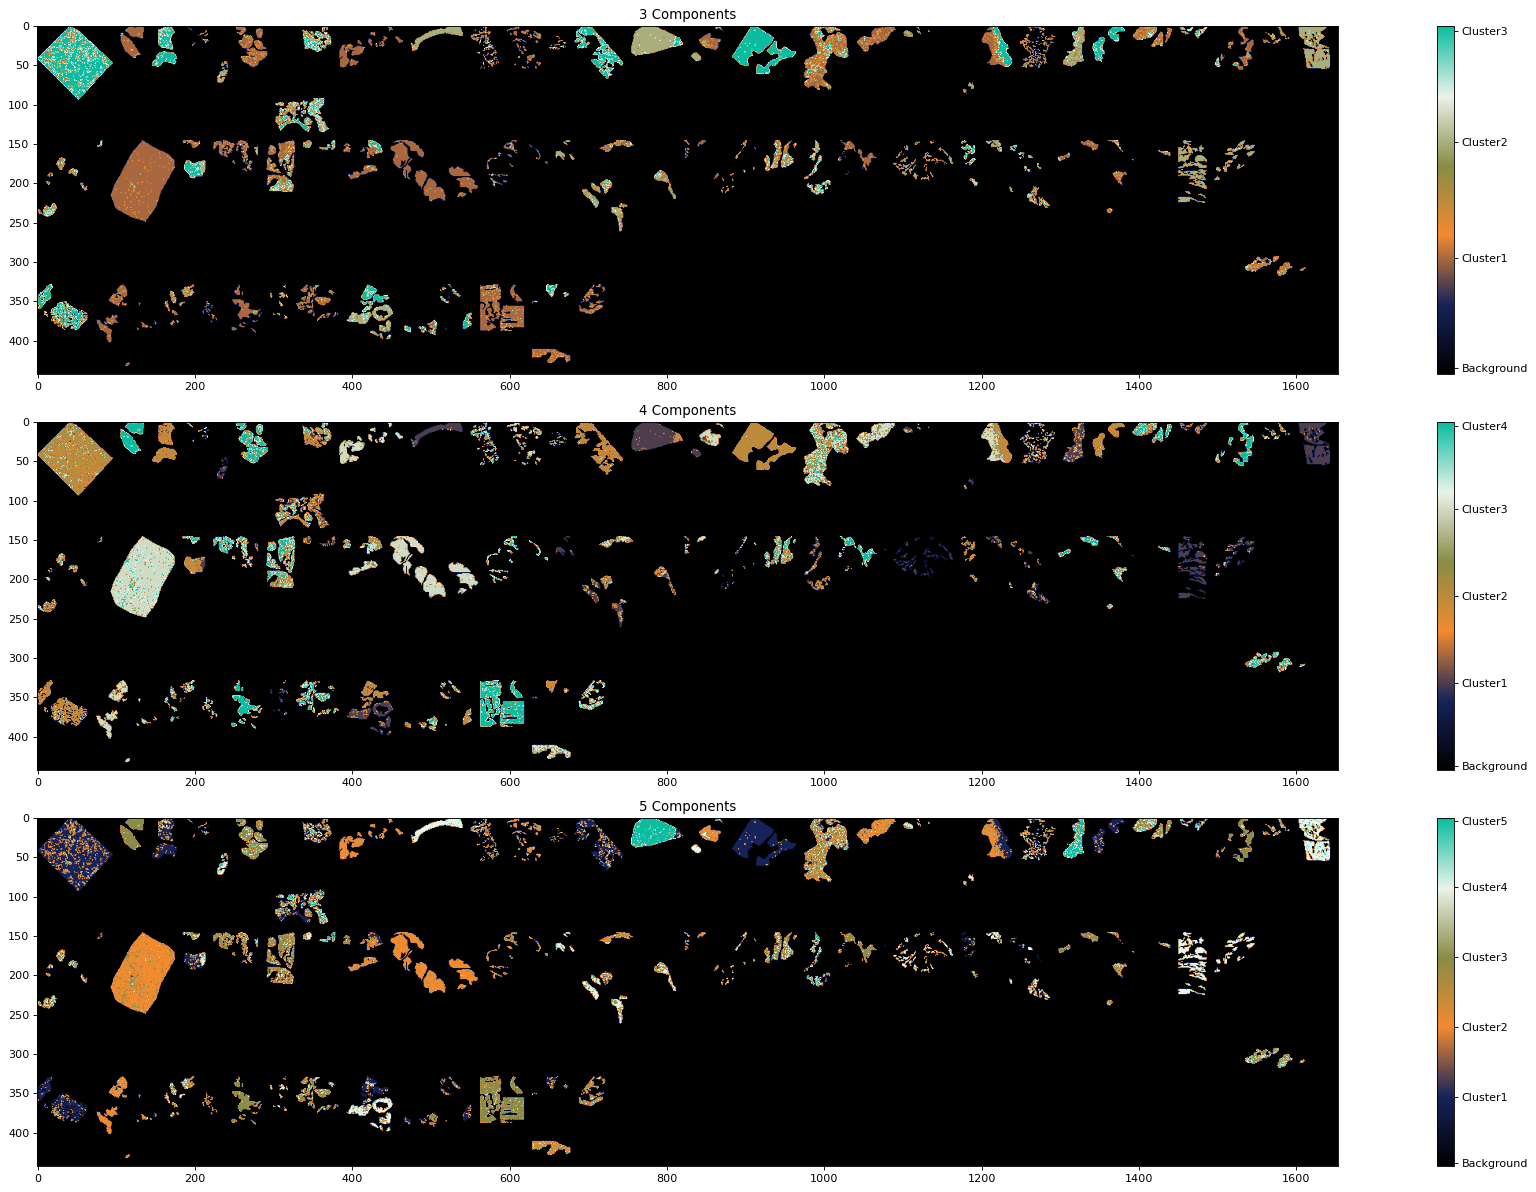

In [60]:
indices_edit = np.where(pixel_to_sample_ID != -1)
bisecting_kmeans_image_3 = np.full( (height,width),-1 )
bisecting_kmeans_image_4 = np.full( (height,width),-1 )
bisecting_kmeans_image_5 = np.full( (height,width),-1 )
increment = 0
for i,j in zip(indices_edit[0],indices_edit[1]):
    bisecting_kmeans_image_3[i][j] = labels_3[increment]
    bisecting_kmeans_image_4[i][j] = labels_4[increment]
    bisecting_kmeans_image_5[i][j] = labels_5[increment]

    increment += 1

cvals = [0, 1, 2,3,4,5]
colors = ["black","#16235A","#F28A30","#888C46", "#EBF2EA","#0ABDA0"] #PURPLE, #DARK BLUE, #

norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = LinearSegmentedColormap.from_list("", tuples)

plt.figure(figsize=(25, 15), dpi=80)
plt.figure(1)
plt.subplot(311)
plt.imshow(bisecting_kmeans_image_3, cmap=cmap)
plt.title("3 Components")
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 1.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3"])

plt.subplot(312)
plt.imshow(bisecting_kmeans_image_4, cmap=cmap)
colorbar = plt.colorbar()
plt.title("4 Components")
colorbar.set_ticks([-0.95 , 0 , 1, 2,2.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3" , "Cluster4"])

plt.subplot(313)
plt.imshow(bisecting_kmeans_image_5, cmap=cmap)
colorbar = plt.colorbar()
plt.title("5 Components")
colorbar.set_ticks([-0.95 , 0 , 1, 2 , 3 , 3.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3","Cluster4","Cluster5"])

plt.tight_layout()
plt.show()


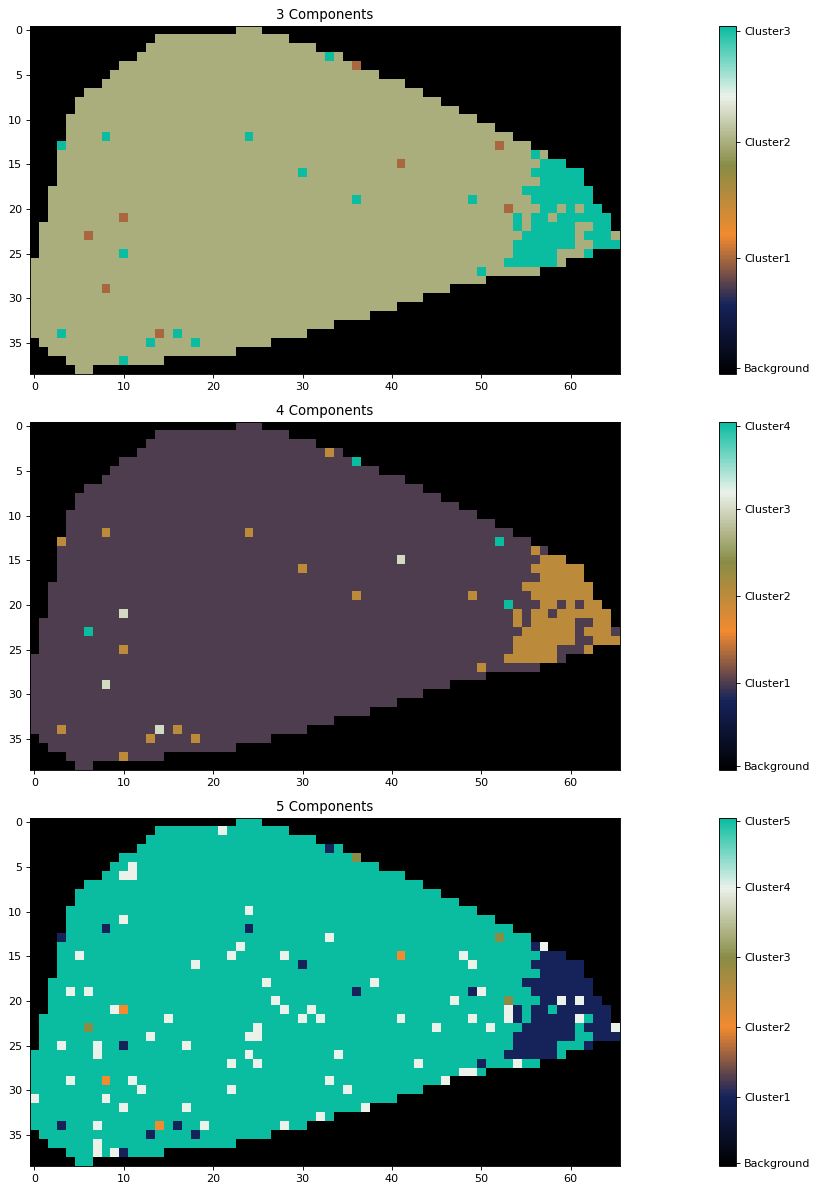

In [61]:
specific_index = 13
mask = (pixel_to_sample_ID == specific_index) 
labels_indicies = np.where(mask == True)

padding_factor = 0

zoomed_height_max = max(labels_indicies[0]) + padding_factor
zoomed_height_min = min(labels_indicies[0]) - padding_factor
zoomed_width_max = max(labels_indicies[1]) + padding_factor
zoomed_width_min = min(labels_indicies[1]) - padding_factor


zoomedIn_image_3 = bisecting_kmeans_image_3[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]
zoomedIn_image_4 = bisecting_kmeans_image_4[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]
zoomedIn_image_5 = bisecting_kmeans_image_5[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]

plt.figure(figsize=(25, 15), dpi=80)
plt.figure(1)
plt.subplot(311)
plt.title("3 Components")
plt.imshow(zoomedIn_image_3, cmap=cmap)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 1.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3"])

plt.subplot(312)
plt.title("4 Components")
plt.imshow(zoomedIn_image_4, cmap=cmap)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 2,2.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3" , "Cluster4"])

plt.subplot(313)
plt.title("5 Components")
plt.imshow(zoomedIn_image_5, cmap=cmap)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 2 , 3 , 3.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3","Cluster4","Cluster5"])

plt.tight_layout()
plt.show()

In [33]:
# Zooming on sample id 13

'''
specific_index = 13
mask = (pixel_to_sample_ID == specific_index) 
kmeans_labels_indicies = np.where(mask == True)

padding_factor = 2

zoomed_height_max = max(kmeans_labels_indicies[0]) + padding_factor
zoomed_height_min = min(kmeans_labels_indicies[0]) - padding_factor
zoomed_width_max = max(kmeans_labels_indicies[1]) + padding_factor
zoomed_width_min = min(kmeans_labels_indicies[1]) - padding_factor


if zoomed_height_max > height:
    zoomed_height_max= height

if zoomed_height_min < 0:
    zoomed_height_min= 0

if zoomed_width_max > width:
    zoomed_width_max= width

if zoomed_width_min < 0:
    zoomed_width_min= 0
    
kmeans_zoomedIn_image = kmeans_image[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]


###############


# Zooming on sample id 13

specific_index = 13
mask = (pixel_to_sample_ID == specific_index) 
tsne_indices = np.where(mask == True)


zoomed_height_max = max(tsne_indices[0]) + padding_factor
zoomed_height_min = min(tsne_indices[0]) - padding_factor
zoomed_width_max = max(tsne_indices[1]) + padding_factor
zoomed_width_min = min(tsne_indices[1]) - padding_factor

if zoomed_height_max > height:
    zoomed_height_max= height

if zoomed_height_min < 0:
    zoomed_height_min= 0

if zoomed_width_max > width:
    zoomed_width_max= width

if zoomed_width_min < 0:
    zoomed_width_min= 0



tsne_zoomedIn_image = tsne_image[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]
'''

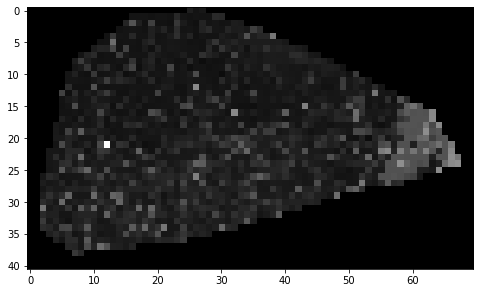

In [36]:
'''
rgb_weights = [0.2989, 0.5870, 0.1140]
grayscale_image = np.dot(tsne_zoomedIn_image[...,:3], rgb_weights)
plt.figure(figsize = (8 , 6))
plt.imshow(grayscale_image,cmap='gray')
'''

In [37]:
'''
def butterLow(cutoff, critical, order):
    normal_cutoff = float(cutoff) / critical
    b, a = signal.butter(order, normal_cutoff, btype='lowpass')
    return b, a

def butterFilter(data, cutoff_freq, nyq_freq, order):
    b, a = butterLow(cutoff_freq, nyq_freq, order)
    y = signal.filtfilt(b, a, data)
    return y
'''

"\ndef butterLow(cutoff, critical, order):\n    normal_cutoff = float(cutoff) / critical\n    b, a = signal.butter(order, normal_cutoff, btype='lowpass')\n    return b, a\n\ndef butterFilter(data, cutoff_freq, nyq_freq, order):\n    b, a = butterLow(cutoff_freq, nyq_freq, order)\n    y = signal.filtfilt(b, a, data)\n    return y\n"

In [38]:
'''

zoomed_heightshape , zoomed_widthshape = grayscale_image.shape
grayscale_image_flattened = grayscale_image.flatten()

cutoff_frequency = 1
sample_rate = np.max(grayscale_image_flattened) * 2 + 1

filtered_image = ( butterFilter(grayscale_image_flattened, cutoff_frequency, sample_rate/2 , 3) ).reshape( zoomed_heightshape , zoomed_widthshape)
plt.imshow(filtered_image)

'''

'\n\nzoomed_heightshape , zoomed_widthshape = grayscale_image.shape\ngrayscale_image_flattened = grayscale_image.flatten()\n\ncutoff_frequency = 1\nsample_rate = np.max(grayscale_image_flattened) * 2 + 1\n\nfiltered_image = ( butterFilter(grayscale_image_flattened, cutoff_frequency, sample_rate/2 , 3) ).reshape( zoomed_heightshape , zoomed_widthshape)\nplt.imshow(filtered_image)\n\n'

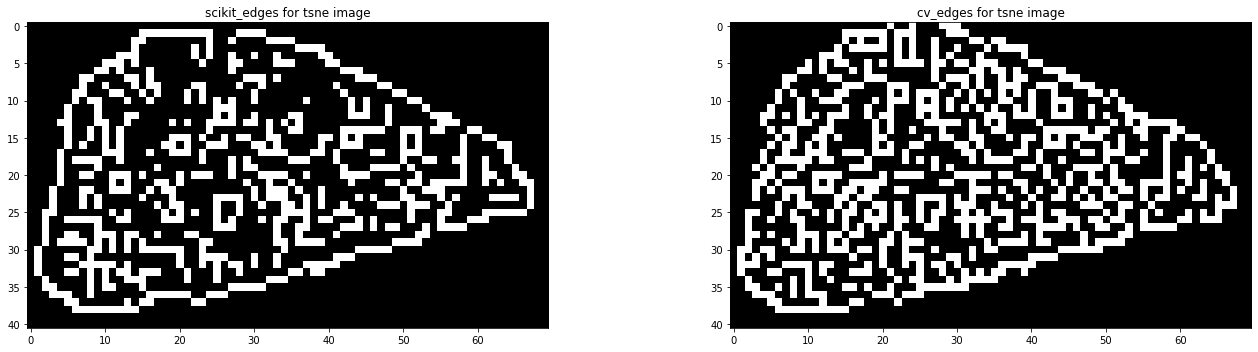

In [39]:
'''
# tSNE edges results

mean = np.mean(grayscale_image.flatten() )

min_threshold = 0.33 * mean
max_threshold = 1.3 * mean

# min_threshold = int(max(0, (1- 0.5)* mean) )
# max_threshold = int(min(255, (1+ 0.5)* mean) )

edges_scikit = feature.canny(grayscale_image, sigma = 0.75, low_threshold = max_threshold , high_threshold = max_threshold)
edge_cv = cv2.Canny((grayscale_image*255).astype(np.uint8) , min_threshold , max_threshold,True)
#blur = cv2.GaussianBlur(grayscale_image,(3,3),0)
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
axes[0].set_title("scikit_edges for tsne image")
axes[1].set_title("cv_edges for tsne image")

axes[0].imshow(edges_scikit,cmap='gray')
axes[1].imshow(edge_cv,cmap='gray')
plt.tight_layout()
'''

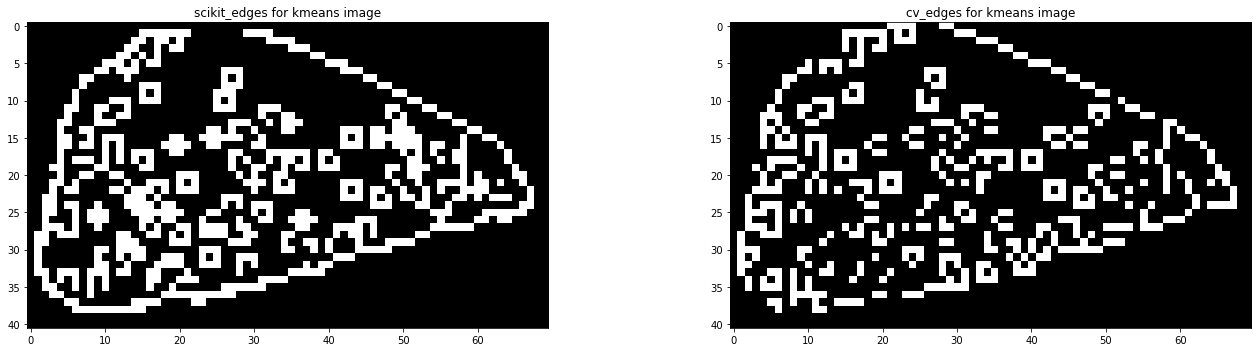

In [40]:
# Kmeans edges results
'''
mean = np.mean(kmeans_zoomedIn_image.flatten() )

min_threshold = 0.33 * mean
max_threshold = 4 * min_threshold

# min_threshold = int(max(0, (1- 0.5)* mean) )
# max_threshold = int(min(255, (1+ 0.5)* mean) )

edges_scikit = feature.canny(kmeans_zoomedIn_image * 255, sigma = 0.06, low_threshold = min_threshold , high_threshold = max_threshold)
edge_cv = cv2.Canny( (kmeans_zoomedIn_image*255).astype(np.uint8) , min_threshold , max_threshold )

#blur = cv2.GaussianBlur(grayscale_image,(3,3),0)


fig, axes = plt.subplots(1, 2, figsize=(20, 5))
axes[0].set_title("scikit_edges for kmeans image")
axes[1].set_title("cv_edges for kmeans image")

axes[0].imshow(edges_scikit,cmap='gray')
axes[1].imshow(edge_cv,cmap='gray')
plt.tight_layout()
'''

## Section 6 - Gaussian Mixture


In [41]:
gmm = GaussianMixture(n_components=3, 
                         max_iter=500, 
                         n_init=10, 
                      covariance_type='diag', verbose=0, random_state=42).fit_predict(op_tsne_results)

gmm_4 = GaussianMixture(n_components=4, 
                         max_iter=500, 
                         n_init=10, 
                      covariance_type='diag', verbose=0, random_state=42).fit_predict(op_tsne_results)

gmm_5 = GaussianMixture(n_components=5, 
max_iter=500, 
n_init=10, 
covariance_type='diag', verbose=0, random_state=42).fit_predict(op_tsne_results)

# plt.scatter(op_tsne_results[:, 0], op_tsne_results[:, 1], c=gmm, s=40, cmap='viridis')


In [42]:
print(np.unique(gmm))

[0 1 2]


In [43]:
indices_edit = np.where(pixel_to_sample_ID != -1)
gaussian_image_3 = np.full( (height,width),-1 )
gaussian_image_4 = np.full( (height,width),-1 )
gaussian_image_5 = np.full( (height,width),-1 )
increment = 0
for i,j in zip(indices_edit[0],indices_edit[1]):
    gaussian_image_3[i][j] = gmm[increment]
    gaussian_image_4[i][j] = gmm_4[increment]
    gaussian_image_5[i][j] = gmm_5[increment]

    increment += 1

In [44]:
cvals = [0, 1, 2,3,4,5]
colors = ["black","#16235A","#F28A30","#888C46", "#EBF2EA","#0ABDA0"] #PURPLE, #DARK BLUE, #

norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = LinearSegmentedColormap.from_list("", tuples)


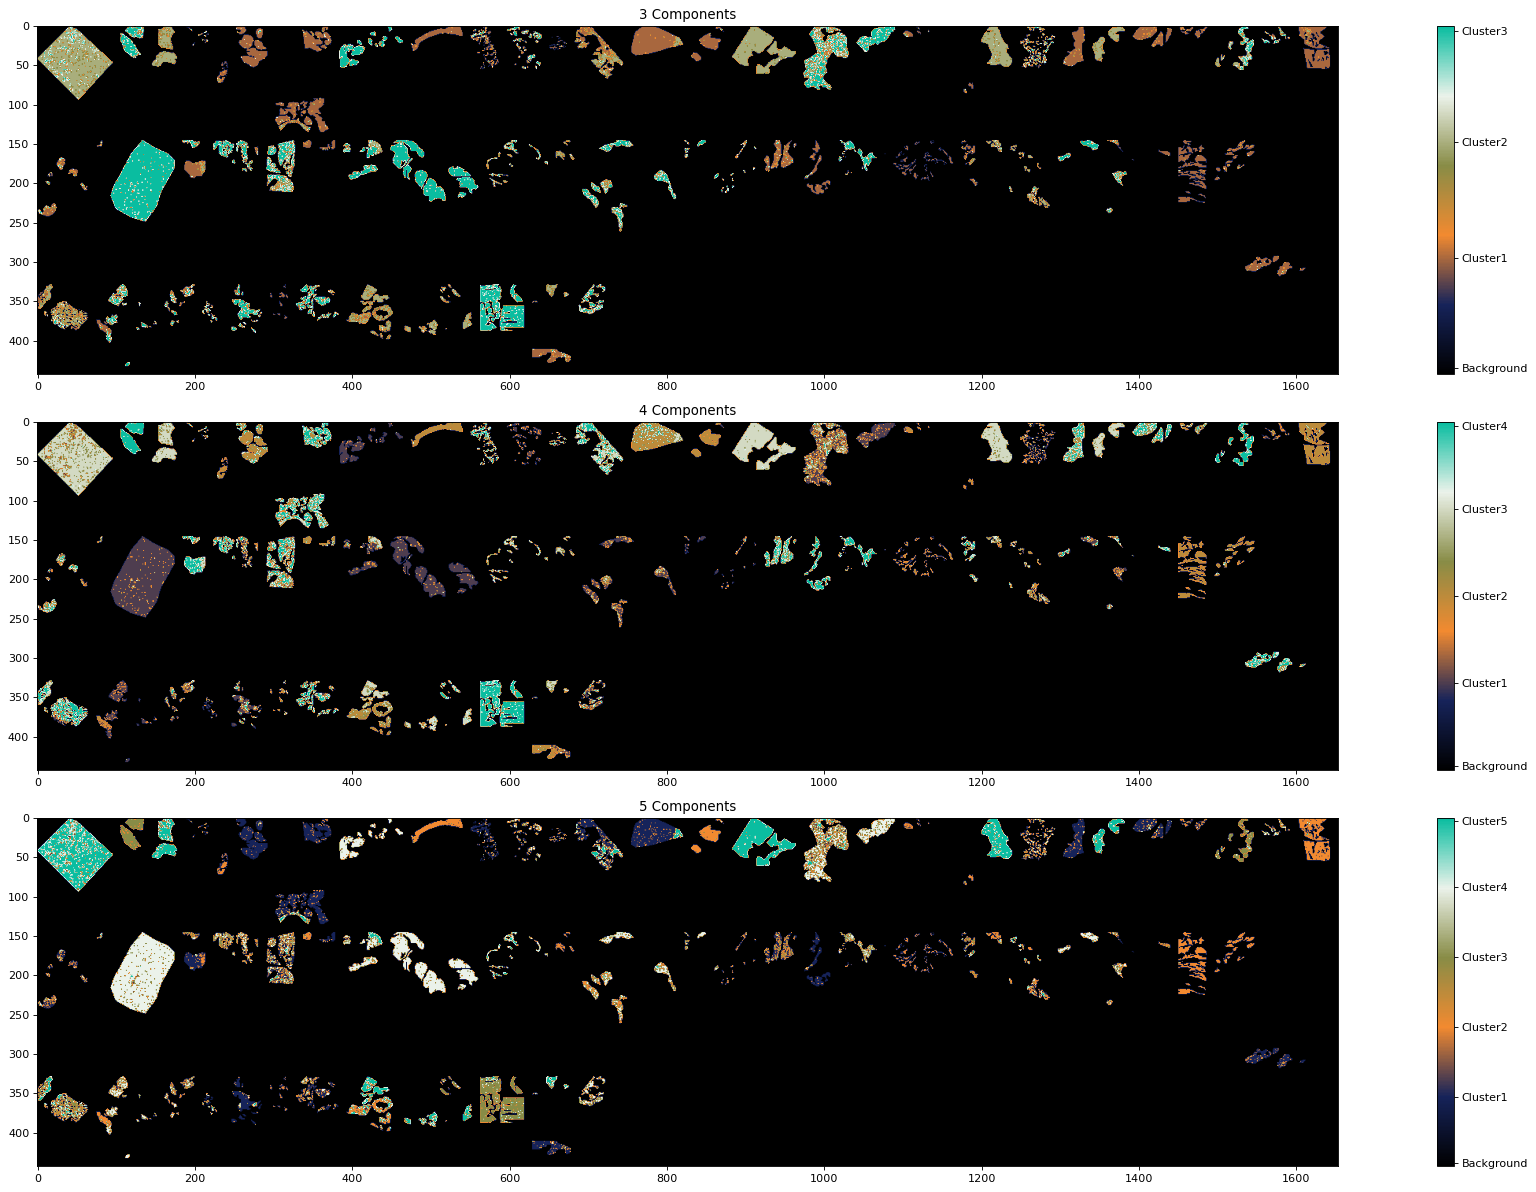

In [58]:
plt.figure(figsize=(25, 15), dpi=80)
plt.figure(1)
plt.subplot(311)
plt.title("3 Components")
plt.imshow(gaussian_image_3, cmap=cmap)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 1.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3"])

plt.subplot(312)
plt.title("4 Components")
plt.imshow(gaussian_image_4, cmap=cmap)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 2,2.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3" , "Cluster4"])


plt.subplot(313)
plt.title("5 Components")
plt.imshow(gaussian_image_5, cmap=cmap)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 2 , 3 , 3.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3","Cluster4","Cluster5"])

plt.tight_layout()
plt.show()


In [46]:
specific_index = 13
mask = (pixel_to_sample_ID == specific_index) 
labels_indicies = np.where(mask == True)

padding_factor = 0

zoomed_height_max = max(labels_indicies[0]) + padding_factor
zoomed_height_min = min(labels_indicies[0]) - padding_factor
zoomed_width_max = max(labels_indicies[1]) + padding_factor
zoomed_width_min = min(labels_indicies[1]) - padding_factor


zoomedIn_image_3 = gaussian_image_3[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]
zoomedIn_image_4 = gaussian_image_4[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]
zoomedIn_image_5 = gaussian_image_5[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]


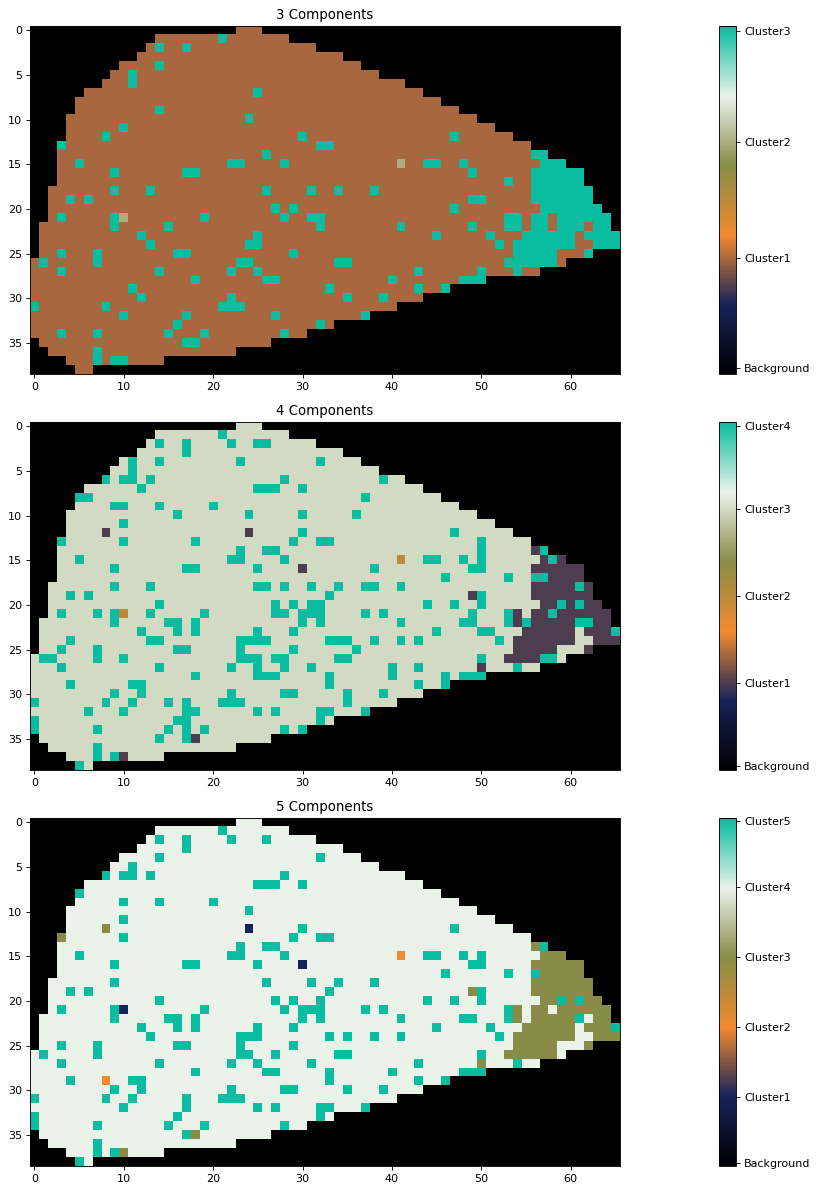

In [59]:
plt.figure(figsize=(25, 15), dpi=80)
plt.figure(1)
plt.subplot(311)
plt.title("3 Components")
plt.imshow(zoomedIn_image_3, cmap=cmap)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 1.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3"])

plt.subplot(312)
plt.title("4 Components")
plt.imshow(zoomedIn_image_4, cmap=cmap)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 2,2.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3" , "Cluster4"])

plt.subplot(313)
plt.title("5 Components")
plt.imshow(zoomedIn_image_5, cmap=cmap)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 2 , 3 , 3.95])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3","Cluster4","Cluster5"])

plt.tight_layout()
plt.show()

In [48]:
'''
model3= GaussianMixture(n_components=3, # this is the number of clusters
                         covariance_type='diag', # {‘full’, ‘tied’, ‘diag’, ‘spherical’}, default=’full’
                         max_iter=100, # the number of EM iterations to perform. default=100
                         n_init=1, # the number of initializations to perform. default = 1
                         init_params='kmeans', # the method used to initialize the weights, the means and the precisions. {'random' or default='k-means'}
                         verbose=0, # default 0, {0,1,2}
                         random_state=1 # for reproducibility
                        )

# Fit the model and predict labels
clust3 = model3.fit(op_tsne_results)
labels3 = model3.predict(op_tsne_results)

# Generate 10,000 new samples based on the model
smpl=model3.sample(n_samples=10000)

# Print model summary
print('*************** 3 Cluster Model ***************')
#print('Weights: ', clust3.weights_)
print('Means: ', clust3.means_)
#print('Covariances: ', clust3.covariances_)
#print('Precisions: ', clust3.precisions_)
#print('Precisions Cholesky: ', clust3.precisions_cholesky_)
print('Converged: ', clust3.converged_)
print(' No. of Iterations: ', clust3.n_iter_)
#print('Lower Bound: ', clust3.lower_bound_)

'''

"\nmodel3= GaussianMixture(n_components=3, # this is the number of clusters\n                         covariance_type='diag', # {‘full’, ‘tied’, ‘diag’, ‘spherical’}, default=’full’\n                         max_iter=100, # the number of EM iterations to perform. default=100\n                         n_init=1, # the number of initializations to perform. default = 1\n                         init_params='kmeans', # the method used to initialize the weights, the means and the precisions. {'random' or default='k-means'}\n                         verbose=0, # default 0, {0,1,2}\n                         random_state=1 # for reproducibility\n                        )\n\n# Fit the model and predict labels\nclust3 = model3.fit(op_tsne_results)\nlabels3 = model3.predict(op_tsne_results)\n\n# Generate 10,000 new samples based on the model\nsmpl=model3.sample(n_samples=10000)\n\n# Print model summary\nprint('*************** 3 Cluster Model ***************')\n#print('Weights: ', clust3.weights_)\

## Canny Edge - ARCHIVED